# Uniform Singular Value Amplification

In this example, We introduce the implementation of uniform singular value amplification.

## What is uniform singular value amplification?
Uniform singular value amplification uniformly amplifies the singular values of a matrix represented as a projected unitary. Suppose that we have access to a unitary $U$, its inverse $U^\dagger$, and the controlled reflection operators $(2\Pi - I)$, $(2\tilde{\Pi}-I)$. We are interested in $A := \tilde{\Pi}U\Pi$, which has a singular value decomposition $A=W\Sigma V$.

## The equivalent problem in function approximation

The goal of uniform singular value amplification is to implement the singular value transformation of $A$ for function $f(x)$. Here, $f(x)$ is a linear function $\lambda x$ over some interval and zero outside the interval.

For numerical demonstration, we consider the target function
$$ f(x)=x/a, \quad x\in[0,a],\quad a=0.2. $$

In [1]:
a = 0.2
targ = lambda x: x / a

To numerically find the best odd polynomial approximating $f(x)$, we use a subroutine which solves the interpolation problem formulated as a convex optimization problem. For this example, we will look for a degree-101 polynomial. We also specify a parameter `delta` to serve as a buffer, i.e., we use the polynomial approximation from $[0,a-\delta]$. Next, we set the parameters for our subroutine. To improve the numerical stability of our method, we scale the target function by a factor of 0.9.

In [2]:
import numpy as np

deg = 101
delta = 0.01
opts = {
    'intervals': [0, a],  # Change to [-1, 1] for QSP operations
    'objnorm': np.inf,
    'epsil': 0.01,
    'npts': 500,
    'fscale': 0.9,
    'isplot': True,
    'method': 'cvxpy'
}

With these parameters set, we can now call our convex optimization subroutine from the `optimization` submodule. The optimization routine will output all Chebyshev coefficients, so we postselect those with the desired parity.

/Users/jameslarsen/miniconda3/envs/qspy/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


norm error = 6.226057844394006e-06
max of solution = 0.9899984954139619


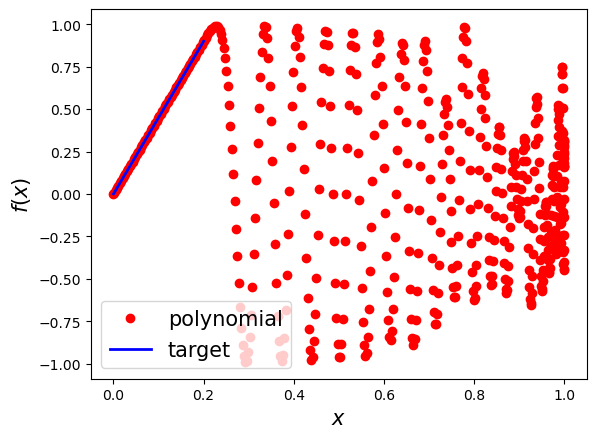

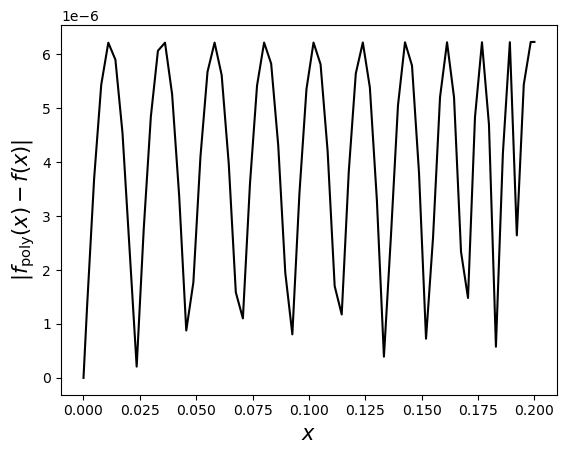

In [3]:
from qsppack.utils import cvx_poly_coef
coef_full = cvx_poly_coef(targ, deg, opts)
parity = deg % 2
coef = coef_full[parity::2]

Above we see that both the $\ell_\infty$-error from the optimization scheme and the maximum value of the solution are outputted by `cvx_poly_coef`. The former verifies suitable convergence, the latter verifies that our polynomial satisfies the constraints. Additionally, since `isplot=True`, plots of the polynomial approximation and its error are shown.

## Solving for phase factors

Now that we have a suitable polynomial approximation for our desired function, we can use the Newton method to solve for phase factors. 

In [4]:
opts.update({
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'targetPre': True,
    'method': 'Newton'
})

from qsppack.solver import solve
phi_proc, out = solve(coef, parity, opts)

iter err          
   1  +7.6677e-01
   2  +2.2044e-01
   3  +4.8863e-02
   4  +5.9244e-03
   5  +1.6429e-04
   6  +1.7844e-07
Stop criteria satisfied.


## Verifying the solution

Finally, we verify the phase factors by computing and plotting the residual error.

The residual error is
3.405054016525355e-13


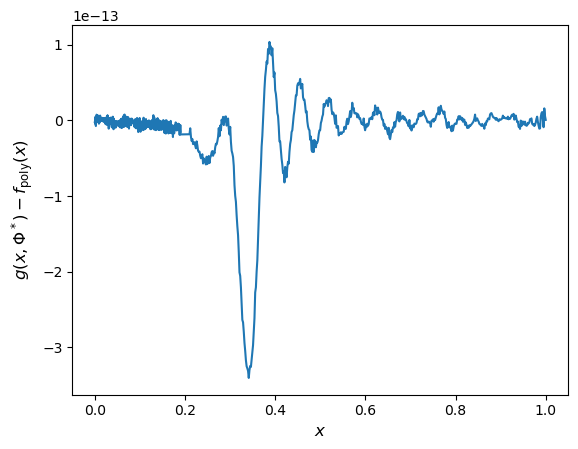

In [5]:
from qsppack.utils import chebyshev_to_func, get_entry
import matplotlib.pyplot as plt

xlist1 = np.linspace(0, a - delta, 500)
xlist2 = np.linspace(a + delta, 1, 500)
xlist = np.concatenate((xlist1, xlist2))
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference

1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).
2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.